In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

from scipy.stats import t, kstest
from scipy.optimize import minimize
import scipy.stats as stats

from datetime import datetime
from tqdm import tqdm

In [2]:
base_colors = ["#14284F", "#EB008B", "#5CD6AE", "#FFB81C", "#C2AFF0",'darkred','orange']
plt.rcParams["axes.prop_cycle"] = plt.cycler(
    color=base_colors 
)

In [3]:
# Define the rolling window size (e.g., 252 trading days for 1 year)
rolling_window = 251 # window to fit GARCH

# Calculate rolling historical VaR at the 99% confidence level
treshold = 0.07

# Number of days to simulate ahead & assess
num_days = 20

# Monte Carlo simulation parameters
num_simulations = 5000  # Number of simulations

# fix imulation with random state
random_number = 42

# Download Prices

In [4]:
# Download S&P 500 data from Yahoo Finance
#'^GSPC'
#'^FTSE' FTSE100
#'^IXIC' Nasdaq composite
#'^FCHI' CAC40
#'^N100' Euronext 100
price = yf.download(['^GSPC', '^FTSE','^FCHI','^N100'], start='1960-01-01', end='2024-05-04')
price.index = pd.to_datetime(price.index)

# Calculate daily log returns
log_returns = np.log(price ['Adj Close'] / price ['Adj Close'].shift(1))
returns = price ['Adj Close'] / price ['Adj Close'].shift(1)-1
# Drop the first row with NaN value
#log_returns = log_returns.dropna()
#returns = returns.dropna()
log_returns.head(5)

[*********************100%%**********************]  4 of 4 completed


Ticker      ^FCHI  ^FTSE     ^GSPC  ^N100
Date                                     
1960-01-04    NaN    NaN       NaN    NaN
1960-01-05    NaN    NaN  0.007980    NaN
1960-01-06    NaN    NaN -0.004315    NaN
1960-01-07    NaN    NaN -0.007344    NaN
1960-01-08    NaN    NaN -0.003188    NaN

In [5]:
log_returns = pd.DataFrame(log_returns)
returns = pd.DataFrame(returns)

# Check distributions

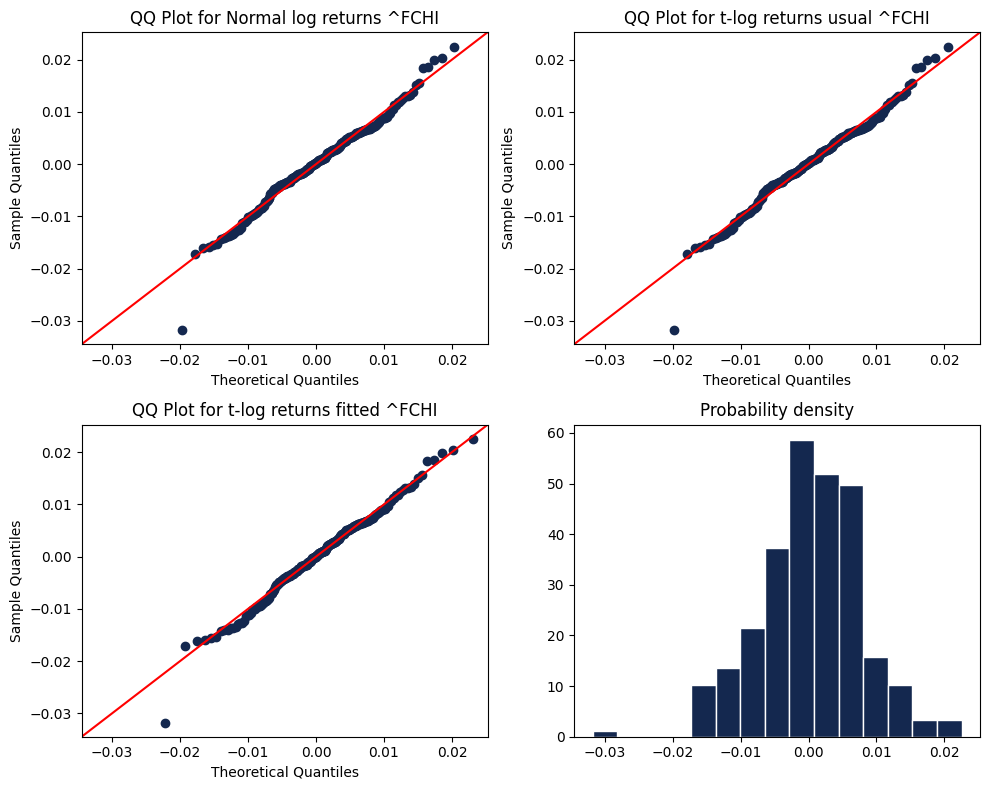

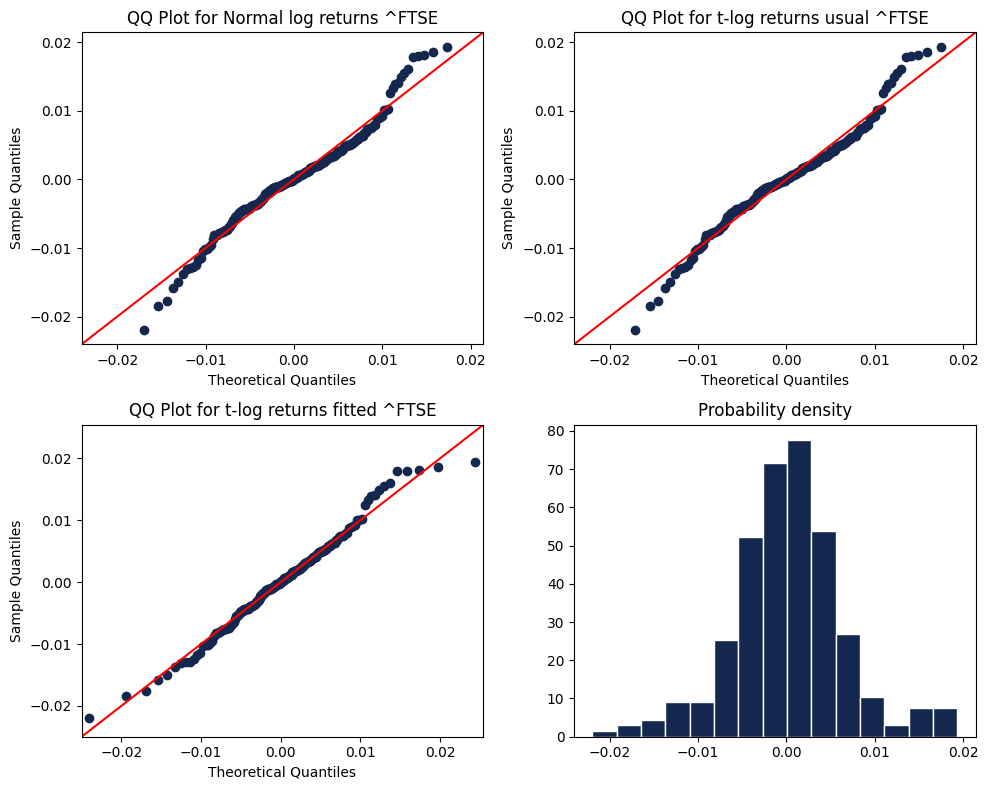

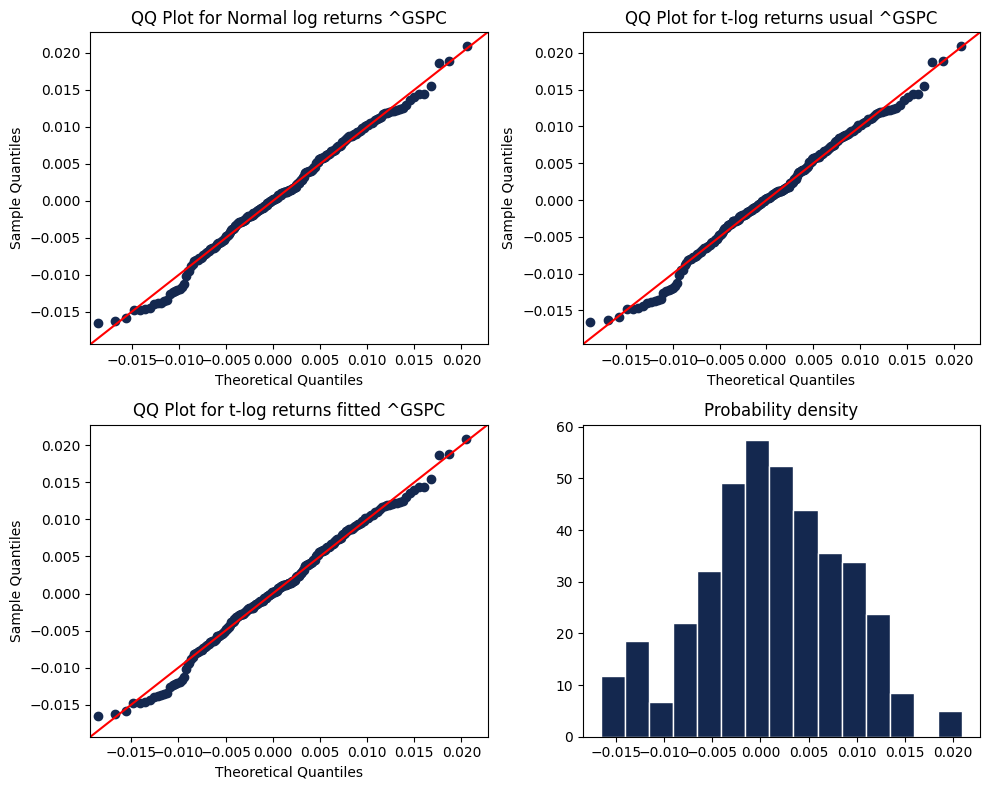

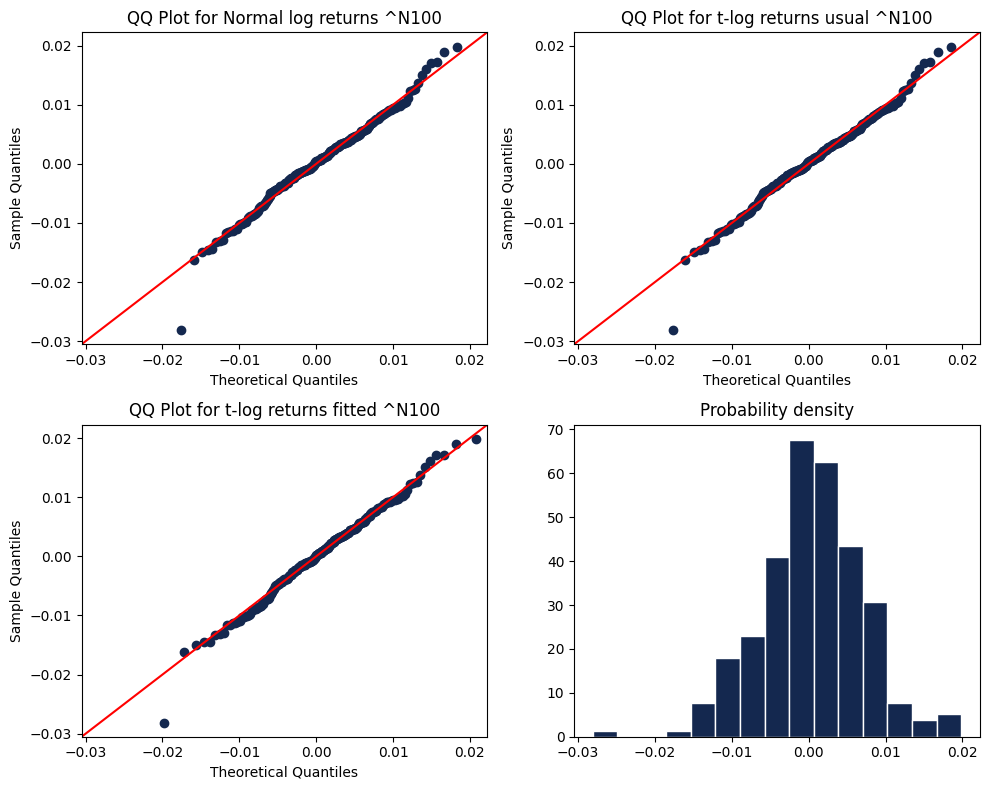

In [6]:
import statsmodels.api as sm

# Function to plot QQ plot
def plot_qq(data, dist, distargs, loc=3, scale=10, name = '', ax = None):
    sm.qqplot(data, dist=dist, distargs=distargs, loc = loc, scale = scale,line='45', ax=ax)
    ax.set_title(f"QQ Plot for {name}")
        
for col in returns.columns:
    arr2 = log_returns[col][-rolling_window:].dropna()
    
    fig, ax = plt.subplots(figsize = (10,8), nrows = 2, ncols = 2)
    
    # Calling and plotting for Normal distribution
    # Make parameters as in Geometric Brownian Motion
    mu = arr2.mean()
    sigma = arr2.std()
    plot_qq(arr2, stats.norm, distargs=(), loc = mu - 0.5*sigma**2, scale = sigma,name ='Normal log returns ' + col, ax = ax[0, 0])
    
    # Calling and plotting for t-distribution
    # did not understand how to implement in VaR simulation, but let it be here
    params  =  stats.t.fit(arr2)
    plot_qq(arr2, stats.t, distargs=(params[0],), loc = params[1], scale = params[2], name ='t-log returns fitted ' +col, ax = ax[1, 0])

    # Do Geometric Brownian Motion, but use t distribution with df = N-1 instead of normal distribution
    plot_qq(arr2, stats.t, distargs=(len(arr2)-1,), loc = mu - 0.5*sigma**2, scale = sigma, name ='t-log returns usual ' +col,
            ax = ax[0, 1])

    ax[1,1].hist(arr2, bins = 15, edgecolor = 'white', density=True)
    ax[1,1].set_title('Probability density')
    
    plt.tight_layout()
    plt.show()

# Run Simulations

In [7]:
def inverse_monte_carlo_var_garch(log_returns, num_simulations, num_days, treshold):
    '''
    This code finds a chance with which losses of value equal or higher than treshold
    will happen in num_days number of cases
    '''

    
    # Fit a GARCH(1,1) model to the log returns
    log_returns = log_returns
    garch_model = arch_model(log_returns*100, vol='Garch', p=1, q=1)
    garch_fit = garch_model.fit(disp='off')
    
    # Get the mean return and GARCH-based forecasted volatility
    mean_return = log_returns.mean()
    forecast = garch_fit.forecast(horizon=num_days)
    std_return = np.sqrt(forecast.variance.values[-1, :])/100
    
    # Simulate future returns for the given number of days
    # T = 1; T is one day
    simulated_log_returns = np.random.normal(mean_return - 0.5*(std_return**2), std_return, (num_simulations, num_days))

    # Calculate cumulative returns for each simulation over the specified number of days
    cumulative_log_returns = simulated_log_returns.sum(axis=1)

    # Find logarithmic value of treshold
    log_treshold = np.log(1-treshold)

    # chance to see these losses
    failure_chance = np.mean(cumulative_log_returns<log_treshold)
    
    return failure_chance

In [8]:
num_simulations = 10000
log_vars = pd.DataFrame(index = log_returns.index)
for col in tqdm(log_returns.columns):
    log_vars.loc[log_returns[col].dropna().index,col] = log_returns[col].dropna().rolling(rolling_window).apply(lambda x: inverse_monte_carlo_var_garch(x,
                                                                                                         num_simulations,
                                                                                                         num_days,
                                                                                                         treshold))

100%|████████████████████████████████████████████| 4/4 [15:48<00:00, 237.22s/it]


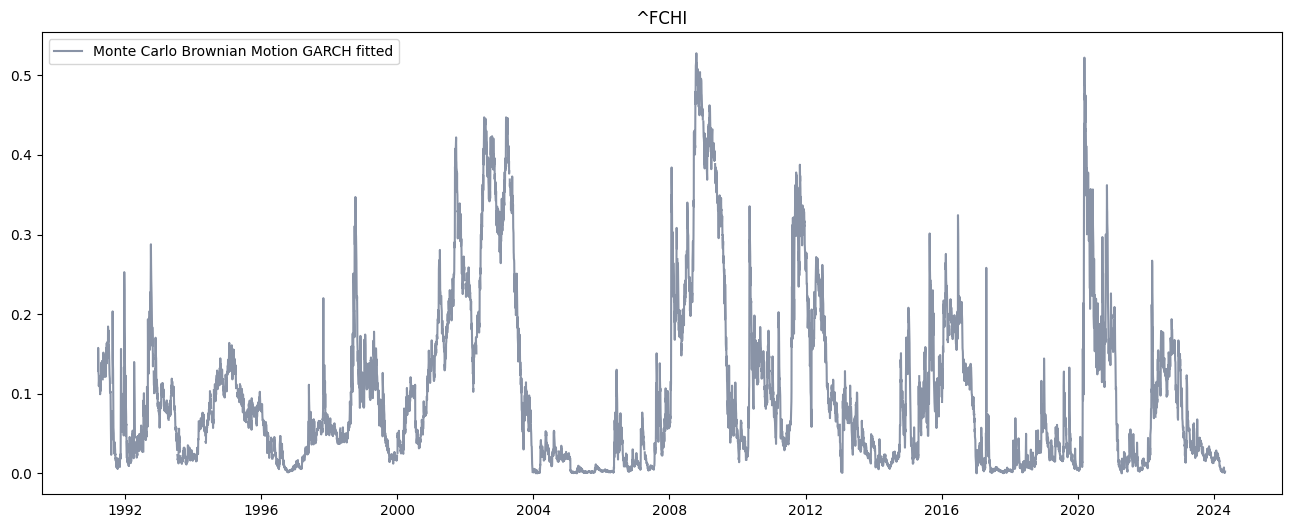

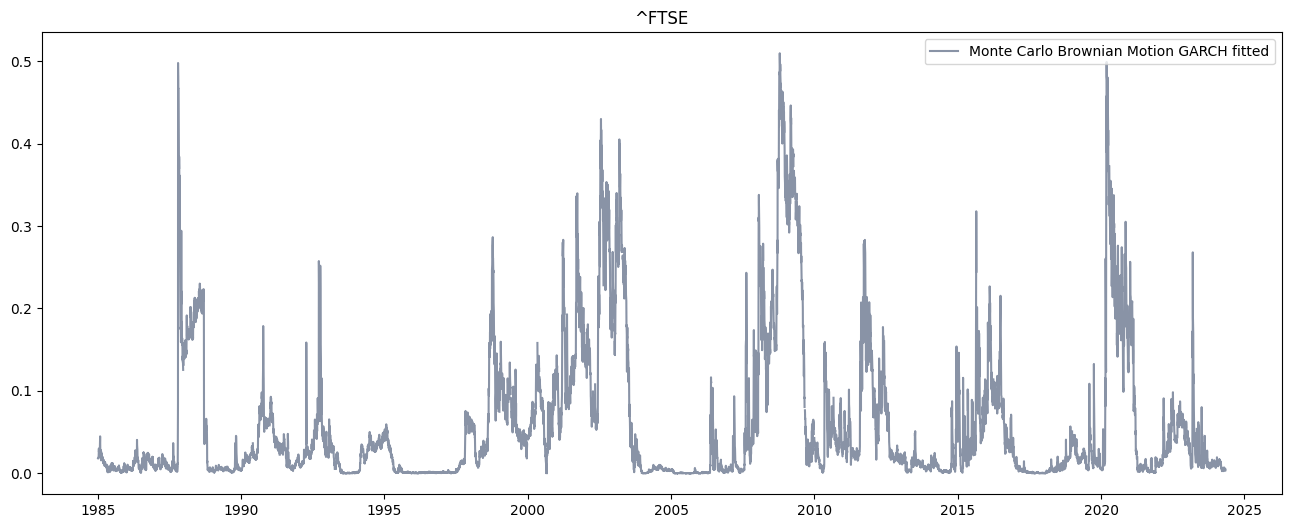

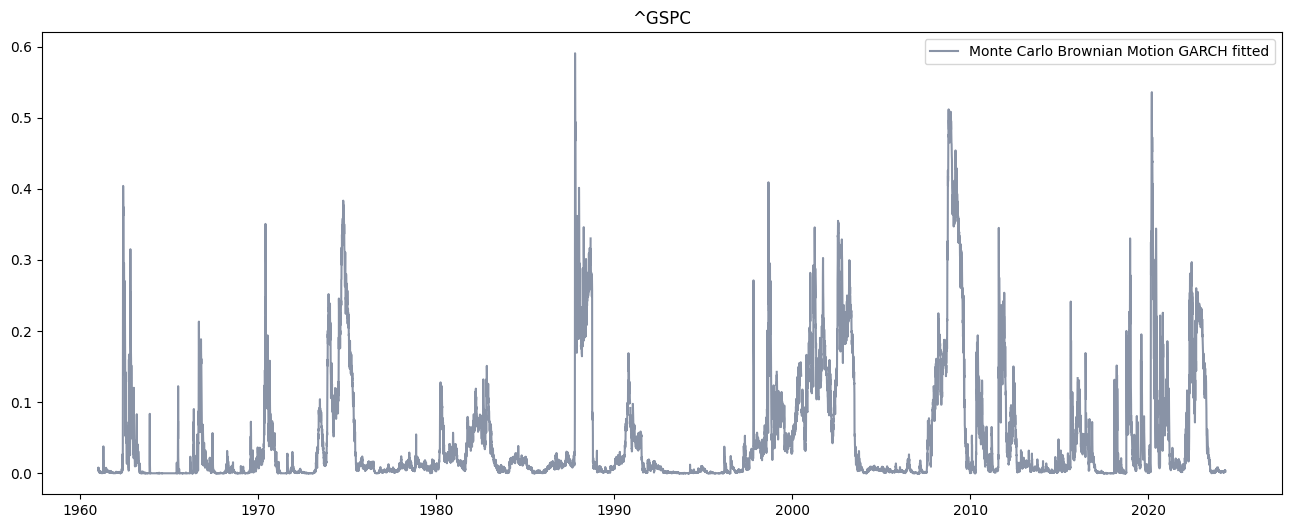

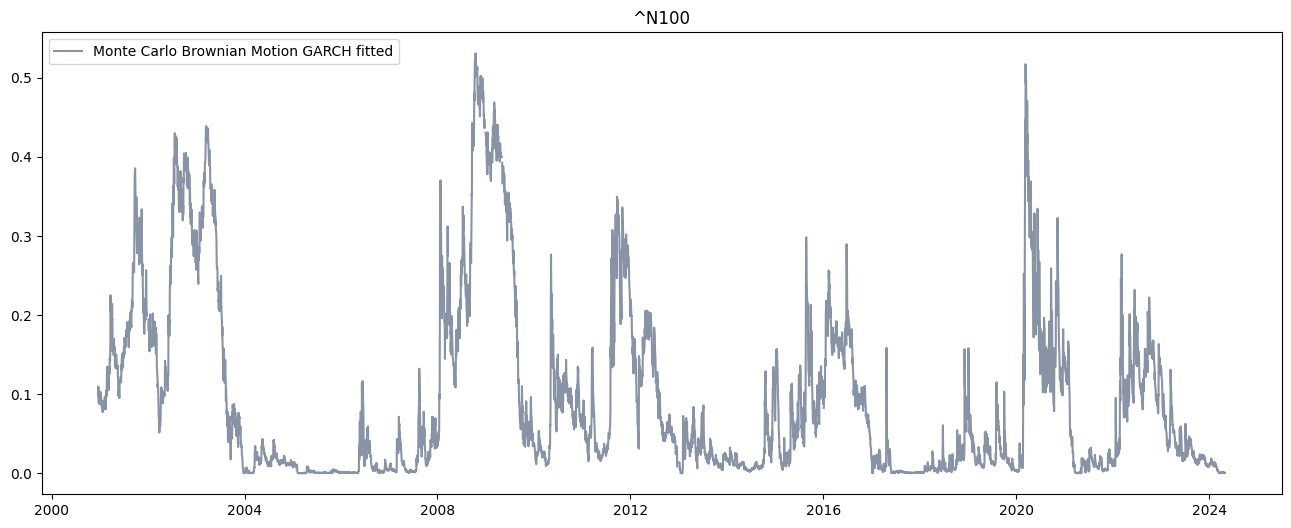

In [9]:
# plot VaRs
for col in log_returns.columns:
    plt.figure(figsize =(16,6))
    plt.title(col)
    #plt.plot(log_returns[col].rolling(num_days).sum(), label = 'cum log returns')
    plt.plot(log_vars[col], alpha = 0.5, label = 'Monte Carlo Brownian Motion GARCH fitted')
    plt.legend();

# Ad VIX

In [10]:
vix = yf.download(['^VIX'], start='1960-01-01', end='2024-05-03')['Adj Close']
vix.index = pd.to_datetime(vix.index)

[*********************100%%**********************]  1 of 1 completed


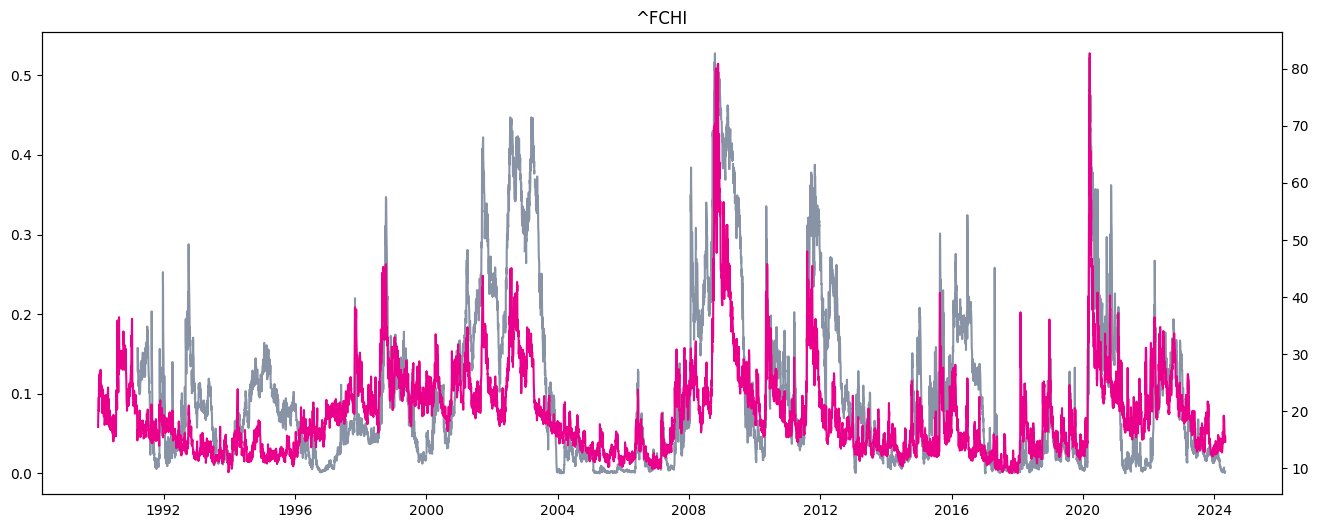

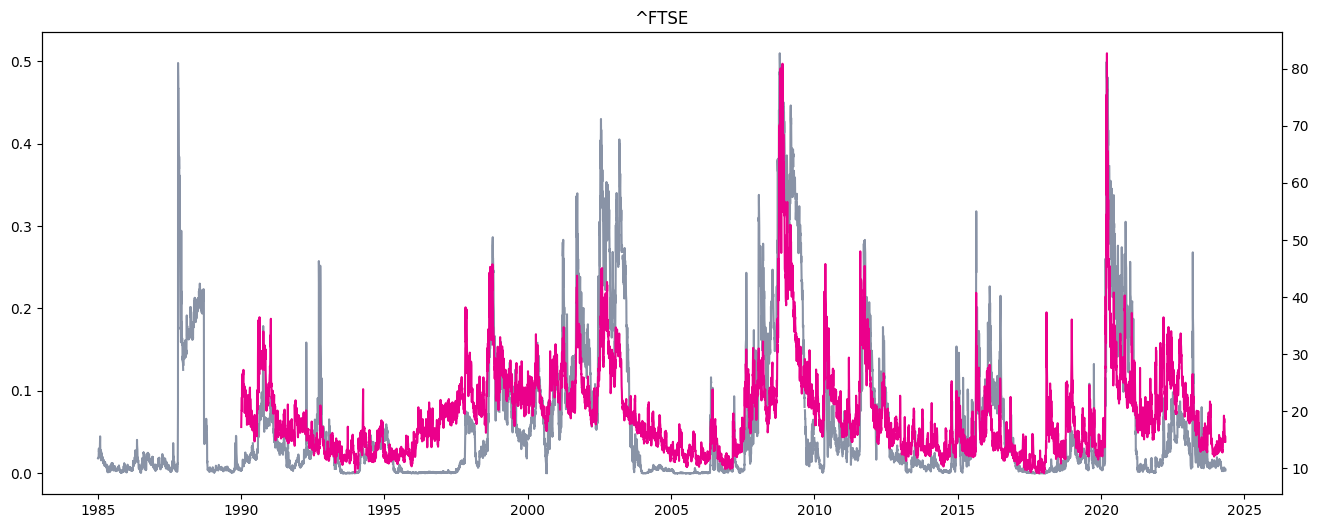

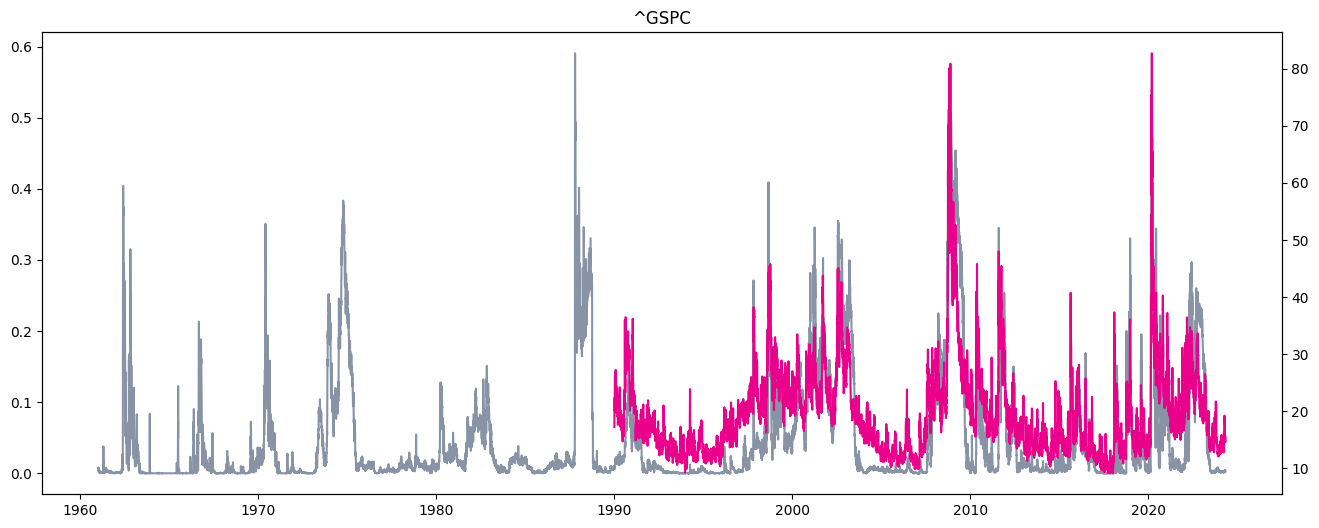

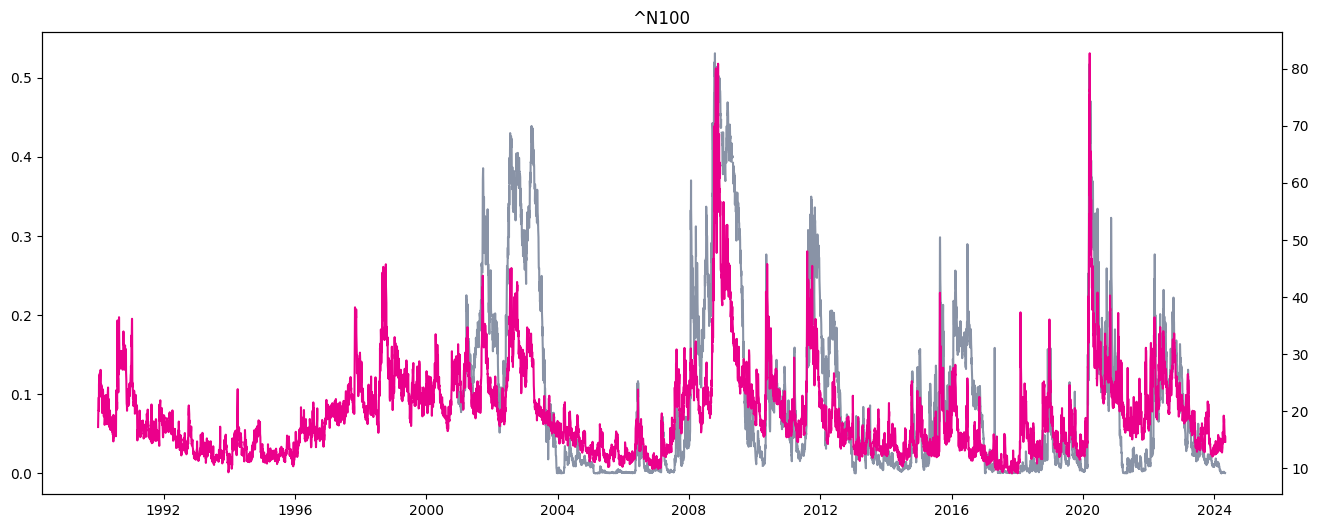

In [11]:
# plot VaRs
for col in log_returns.columns:
    fig, ax1 = plt.subplots(figsize =(16,6))
    ax1.set_title(col)
    #plt.plot(log_returns[col].rolling(num_days).sum(), label = 'cum log returns')
    ax1.plot(log_vars[col], alpha = 0.5, label = 'Monte Carlo Brownian Motion GARCH fitted')
    ax2 = ax1.twinx()
    ax2.plot(vix, color = base_colors[1])
    plt.show();

# Test strategy

Invest in asset (1-2*value of the indicator); where value of indicator cannot be higher than 0.5. Therefore firstly need a fix

In [68]:
#log_vars[col]
class strategy_testing():
    """
    This class tests different strategies of signal VS prices
    """
    def __init__(self, signal, returns, lag_of_implementation,starting_date = '1900-01-01', ending_date = '2100-01-01'):
        common_index = sorted(list(set(signal.dropna()[starting_date: ending_date].index).intersection(set(returns.dropna().index))))
        self.signal = signal.loc[common_index]
        self.returns = returns.loc[common_index]

        self.signal = self.signal.shift(lag_of_implementation)
        self.signal = self.signal.dropna()
        self.returns = self.returns.loc[self.signal.index]

    def invest_one_minus_alpha_signal(self, alpha, is_long_only = True):
        temporary_signal = 1 - alpha*self.signal
        if is_long_only:
            temporary_signal[temporary_signal <0] = 0
        strategy_returns = temporary_signal * self.returns
        return strategy_returns
        
    def treshold_long_short(self, treshold, is_long_only= True):
        """
        high volatility => desinvest / short
        """

        if is_long_only:
            temporary_signal = self.signal < treshold
            temporary_signal = temporary_signal.astype(int)
        else:
            temporary_signal = self.signal < treshold
            temporary_signal = (2*temporary_signal).astype(int)-1
            
        strategy_returns = temporary_signal * self.returns
        return strategy_returns

    def inverse_treshold_long_short(self, treshold, is_long_only= True):
        """
        low volatility => desinvest / short
        high volatility => invest
        """

        if is_long_only:
            temporary_signal = self.signal >= treshold
            temporary_signal = temporary_signal.astype(int)
        else:
            temporary_signal = self.signal >= treshold
            temporary_signal = (2*temporary_signal).astype(int)-1
            
        strategy_returns = temporary_signal * self.returns
        return strategy_returns

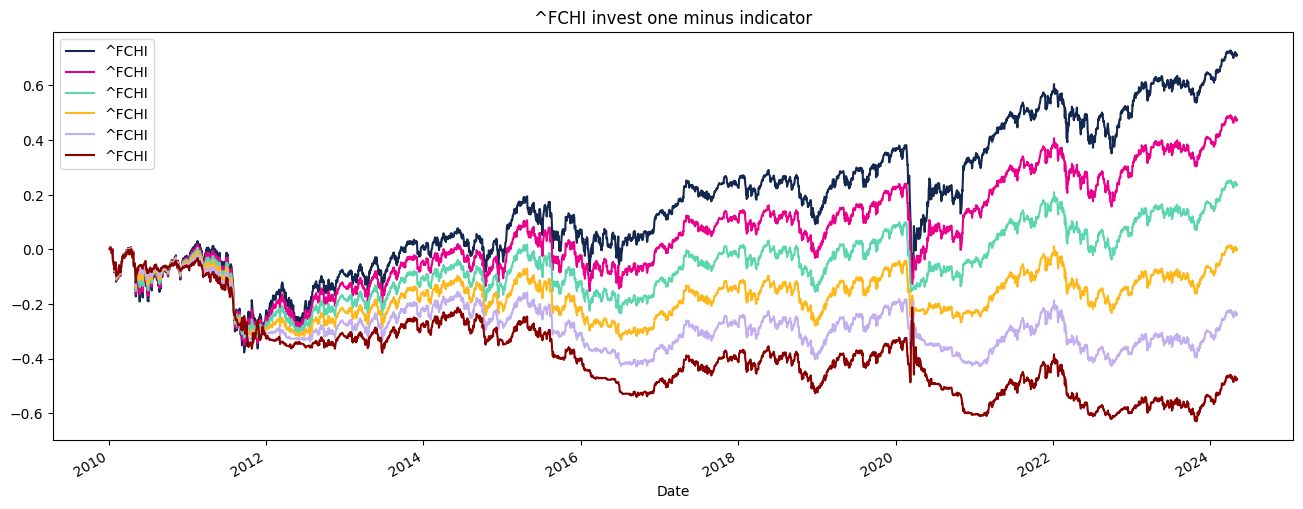

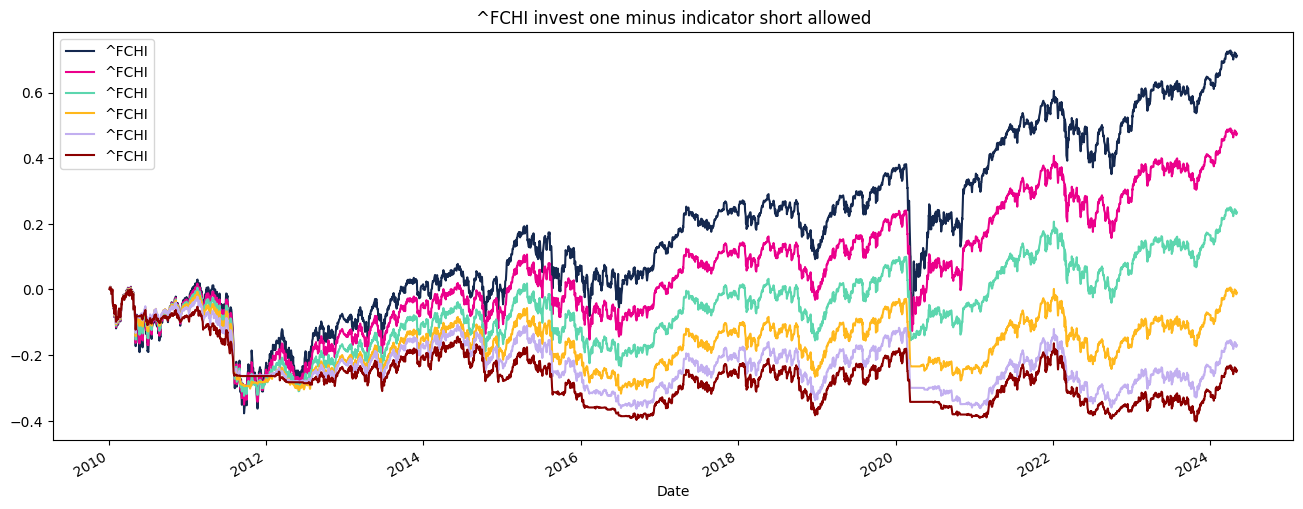

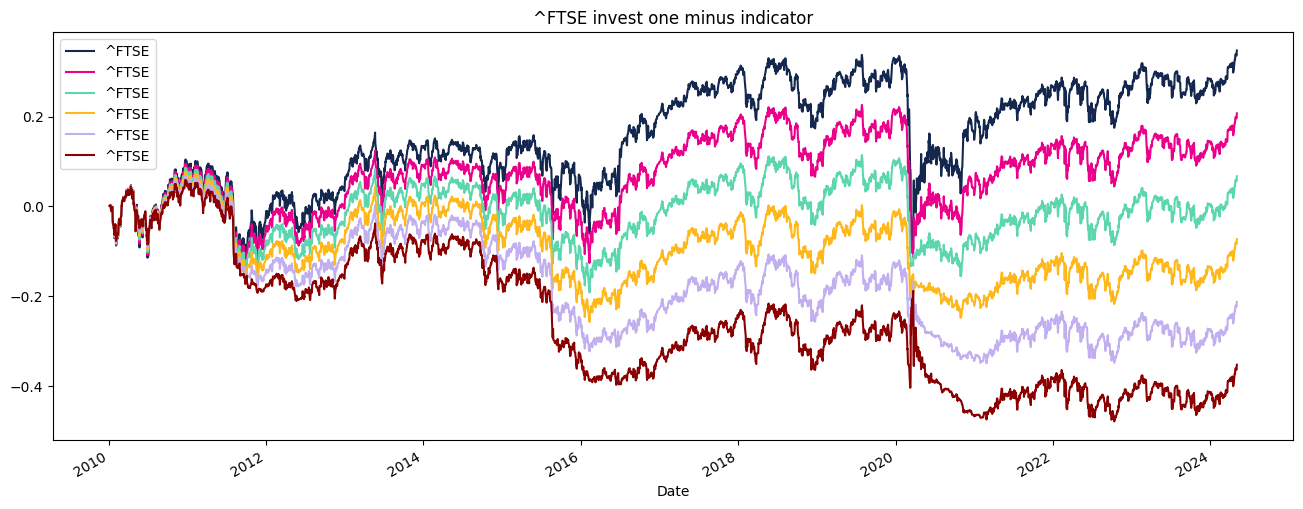

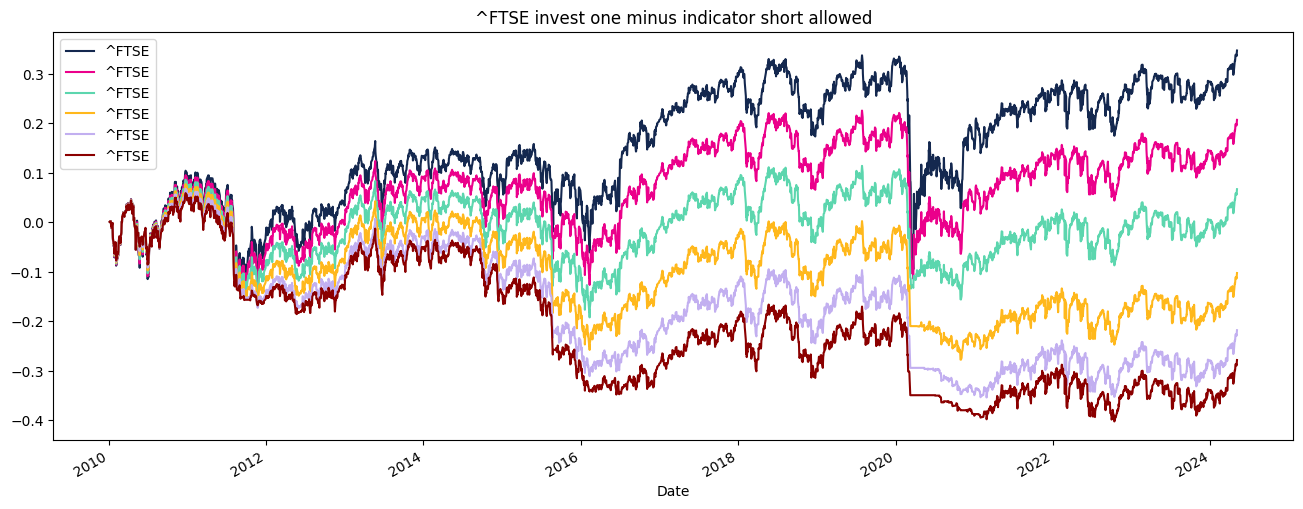

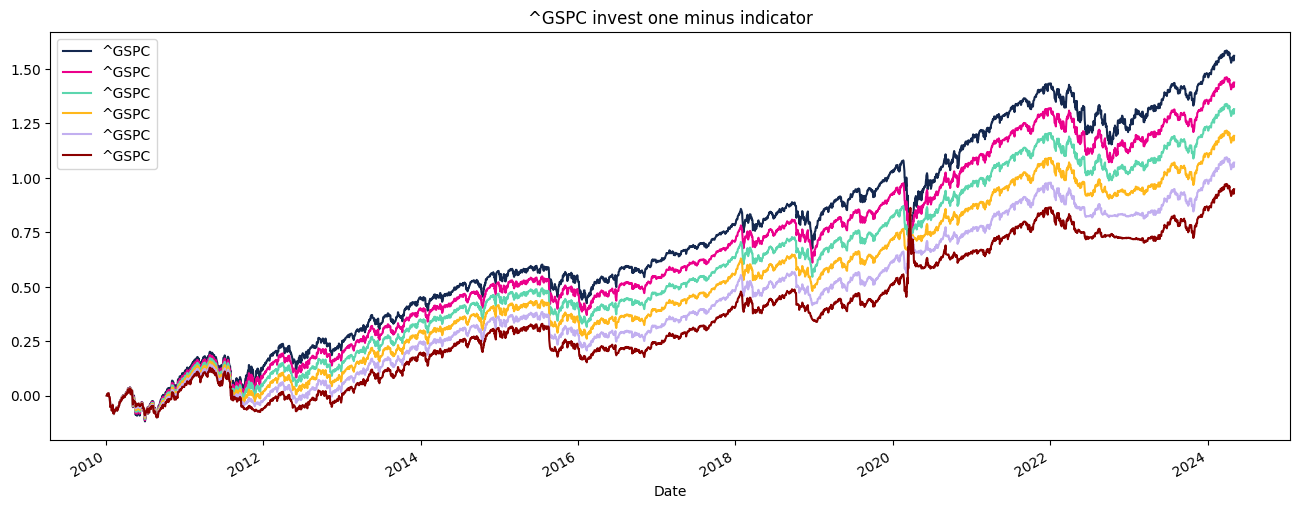

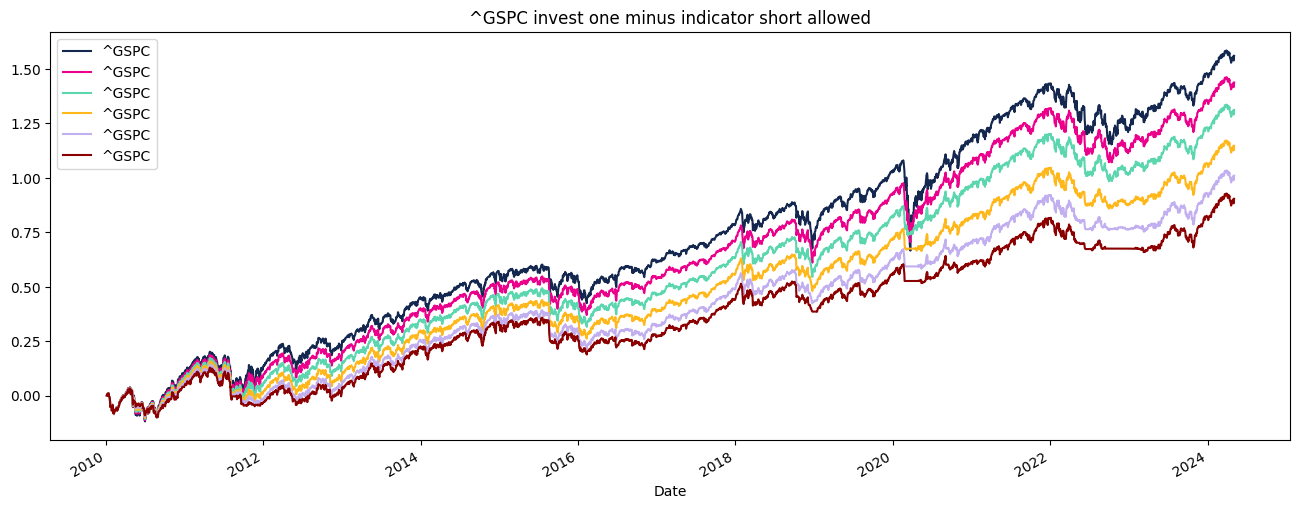

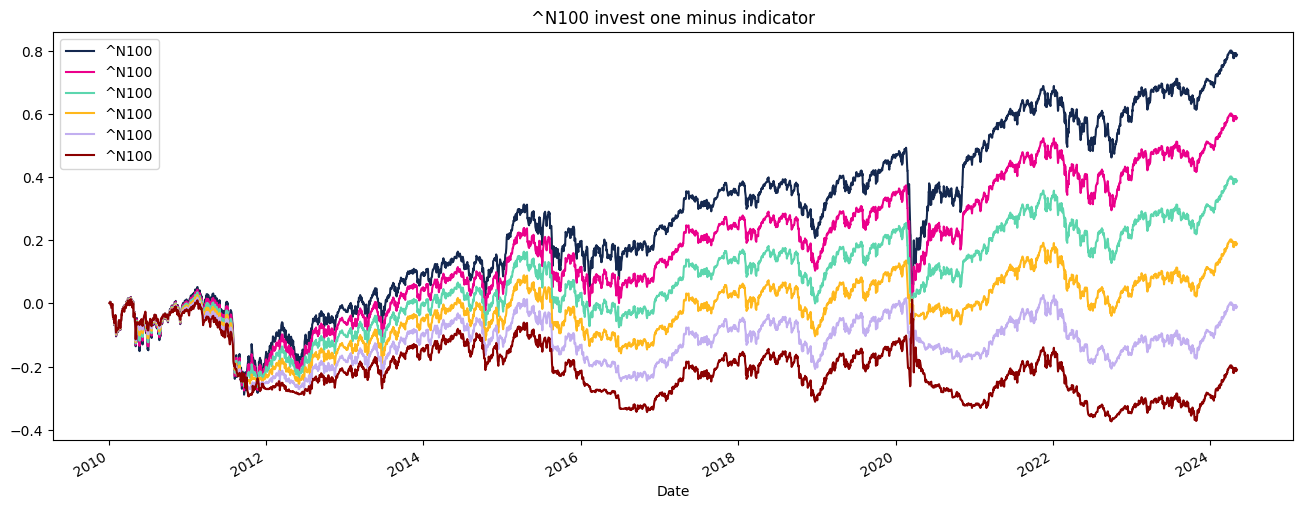

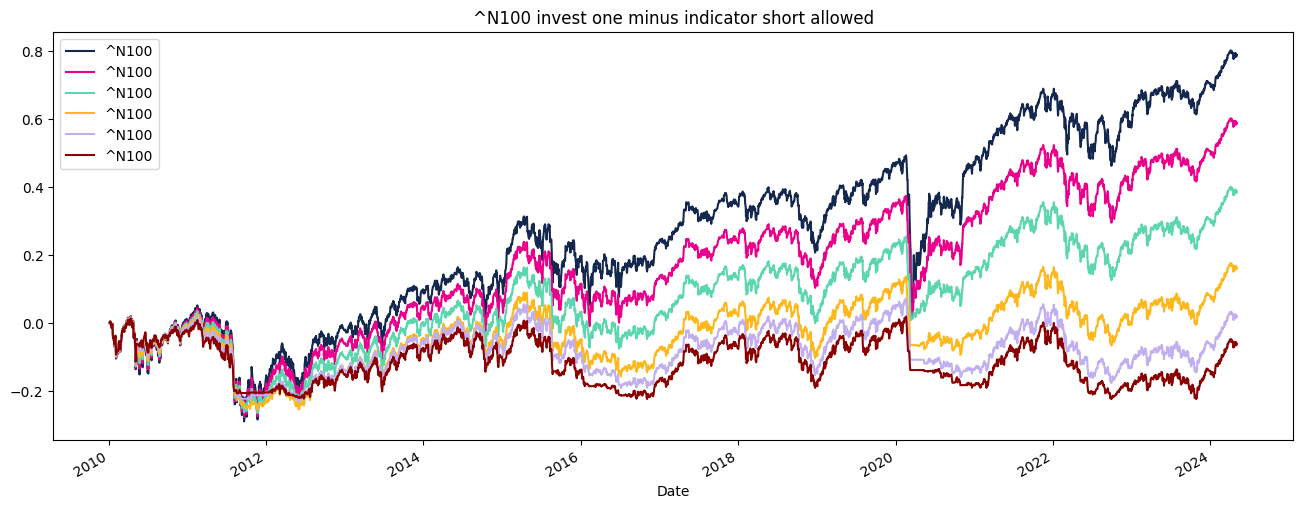

In [53]:
for col in log_returns.columns:
    strategy_one_minus_alpha = strategy_testing(log_vars[col],log_returns[col],2,starting_date = '2010-01-01')
    
    plt.figure(figsize = (16,6))
    plt.title(col + ' invest one minus indicator')
    
    strategy_one_minus_alpha.returns.cumsum().plot(legend = 'initial indicator')#.rolling(252).mean().plot()
    strategy_one_minus_alpha.invest_one_minus_alpha_signal(1,is_long_only = False).cumsum().plot(legend = 'alpha 1')#.rolling(252).mean().plot()
    strategy_one_minus_alpha.invest_one_minus_alpha_signal(2,is_long_only = False).cumsum().plot(legend = 'alpha 2')#.rolling(252).mean().plot()
    strategy_one_minus_alpha.invest_one_minus_alpha_signal(3,is_long_only = False).cumsum().plot(legend = 'alpha 3')#.rolling(252).mean().plot()
    strategy_one_minus_alpha.invest_one_minus_alpha_signal(4,is_long_only = False).cumsum().plot(legend = 'alpha 4')#.rolling(252).mean().plot()
    strategy_one_minus_alpha.invest_one_minus_alpha_signal(5,is_long_only = False).cumsum().plot(legend = 'alpha 5')#.rolling(252).mean().plot()


    plt.figure(figsize = (16,6))
    plt.title(col + ' invest one minus indicator short allowed')
    
    strategy_one_minus_alpha.returns.cumsum().plot(legend = 'initial indicator')#.rolling(252).mean().plot()
    strategy_one_minus_alpha.invest_one_minus_alpha_signal(1,is_long_only = True).cumsum().plot(legend = 'alpha 1')#.rolling(252).mean().plot()
    strategy_one_minus_alpha.invest_one_minus_alpha_signal(2,is_long_only = True).cumsum().plot(legend = 'alpha 2')#.rolling(252).mean().plot()
    strategy_one_minus_alpha.invest_one_minus_alpha_signal(3,is_long_only = True).cumsum().plot(legend = 'alpha 3')#.rolling(252).mean().plot()
    strategy_one_minus_alpha.invest_one_minus_alpha_signal(4,is_long_only = True).cumsum().plot(legend = 'alpha 4')#.rolling(252).mean().plot()
    strategy_one_minus_alpha.invest_one_minus_alpha_signal(5,is_long_only = True).cumsum().plot(legend = 'alpha 5')#.rolling(252).mean().plot()

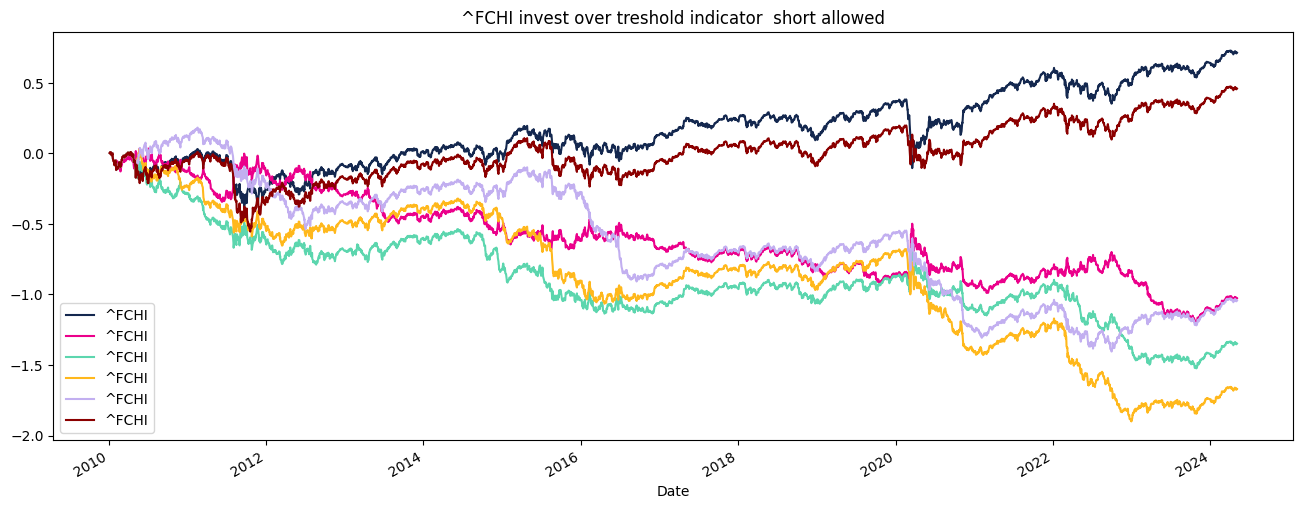

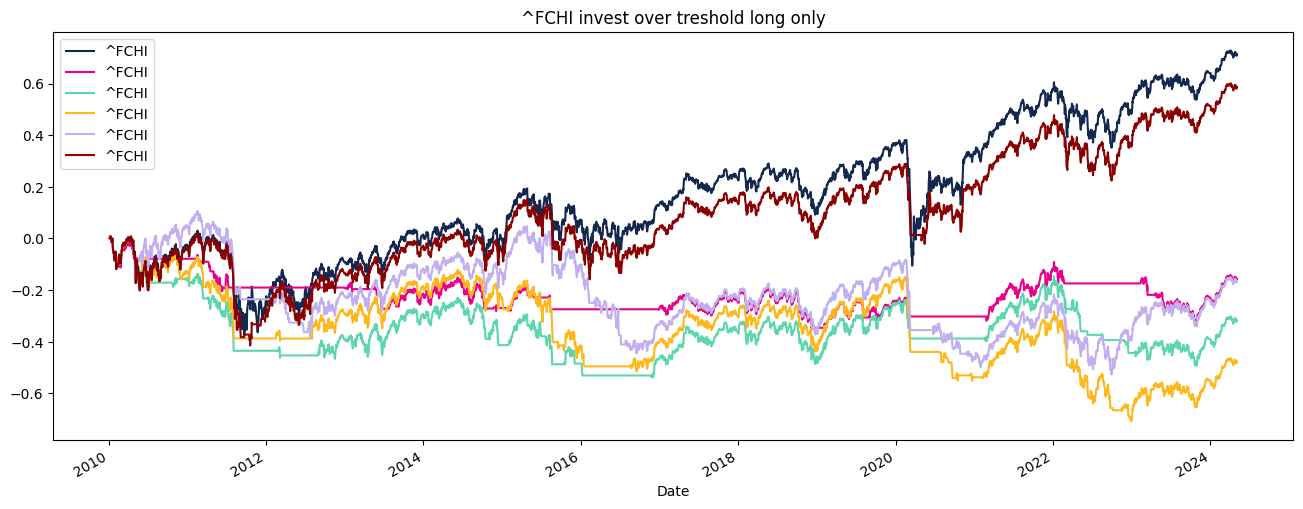

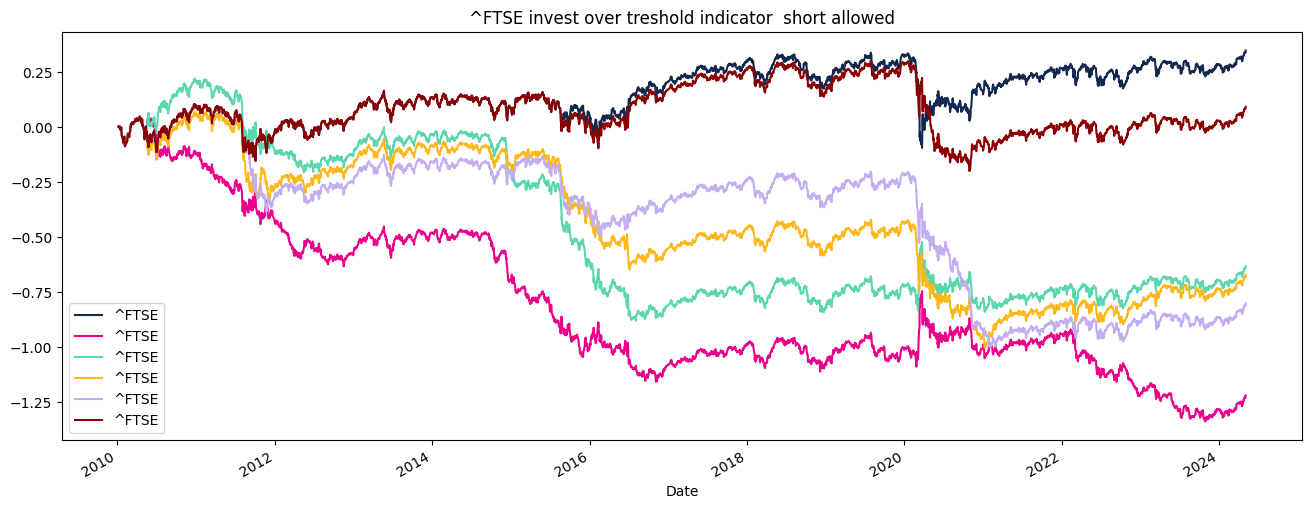

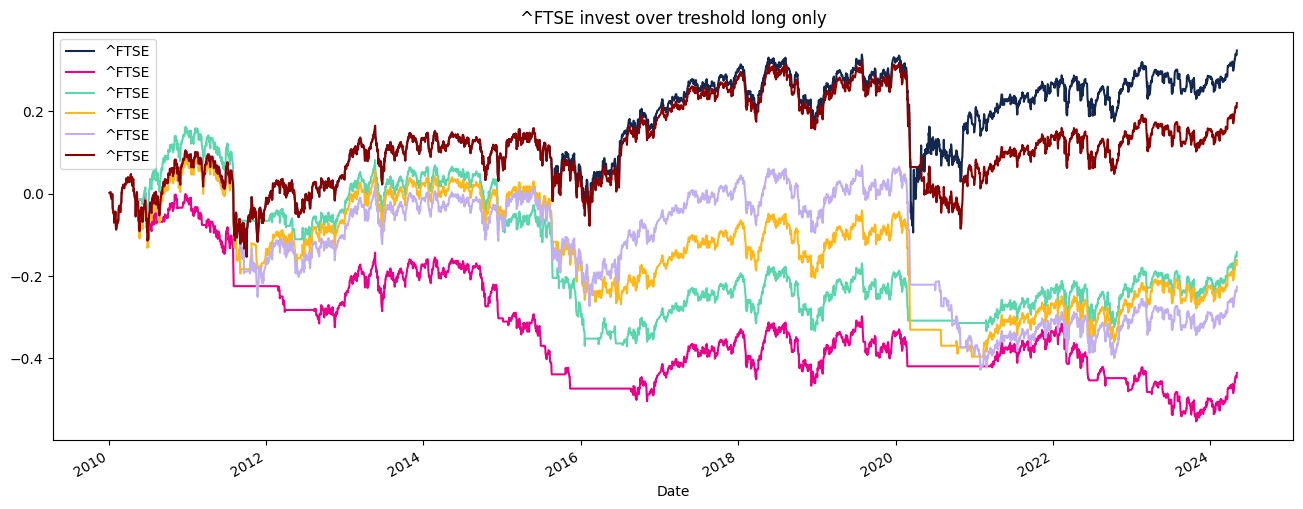

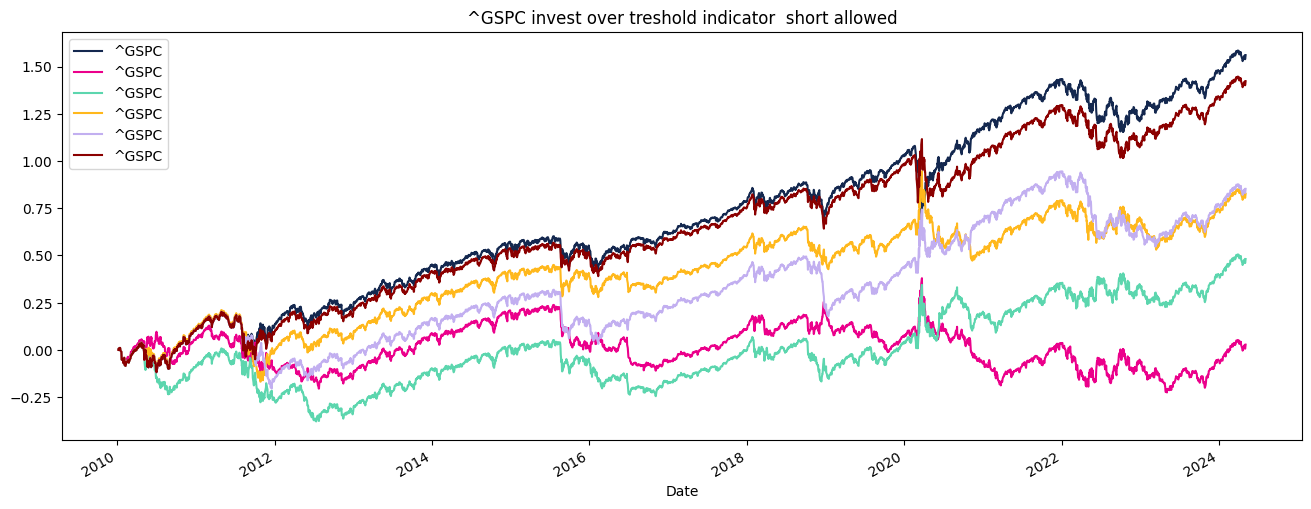

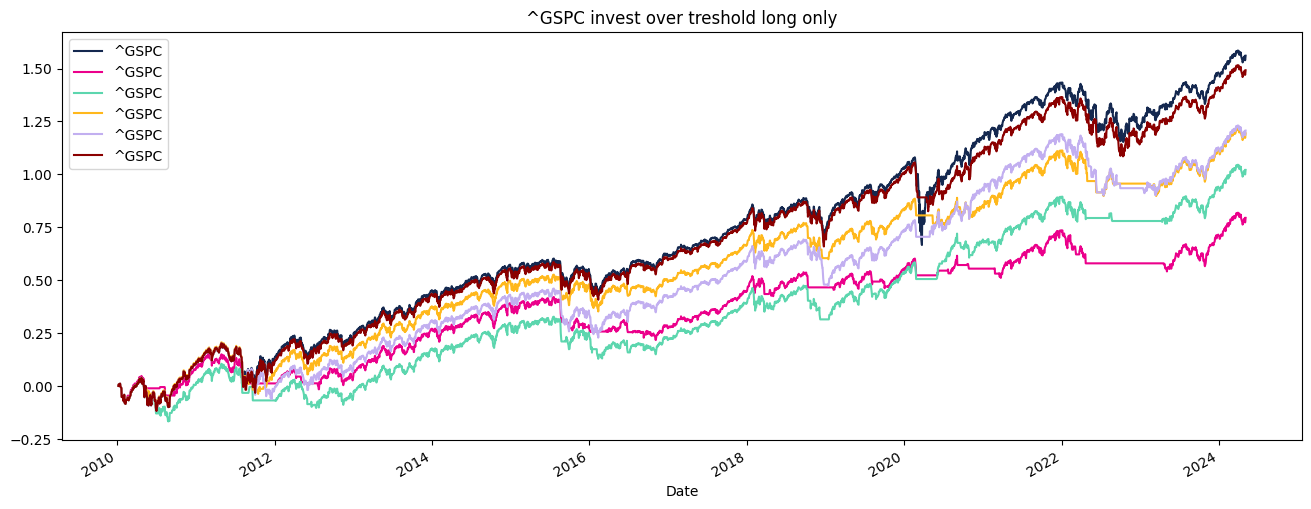

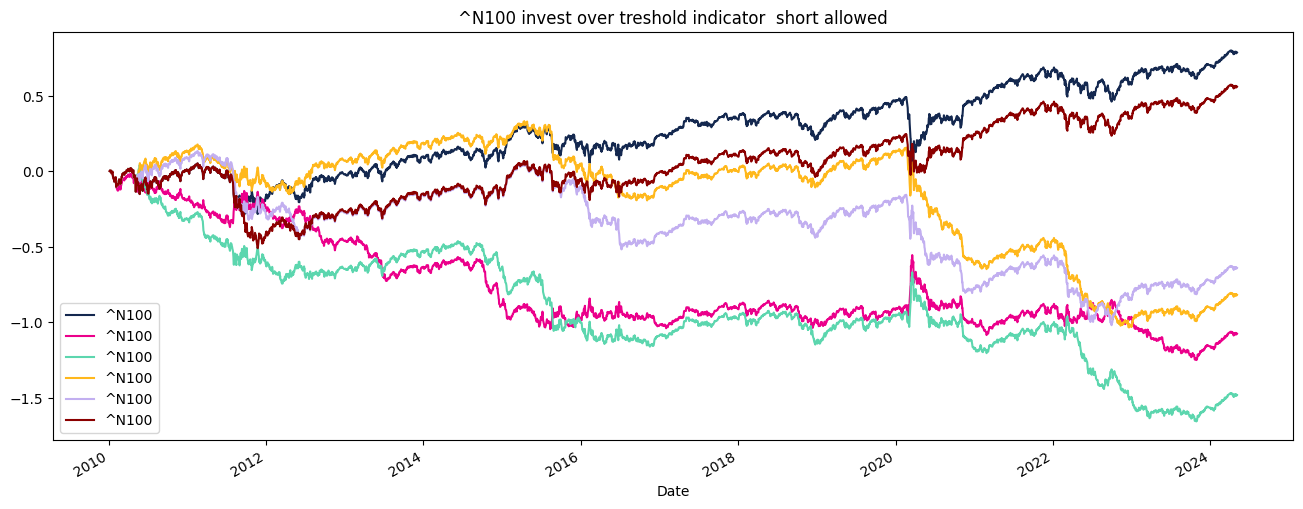

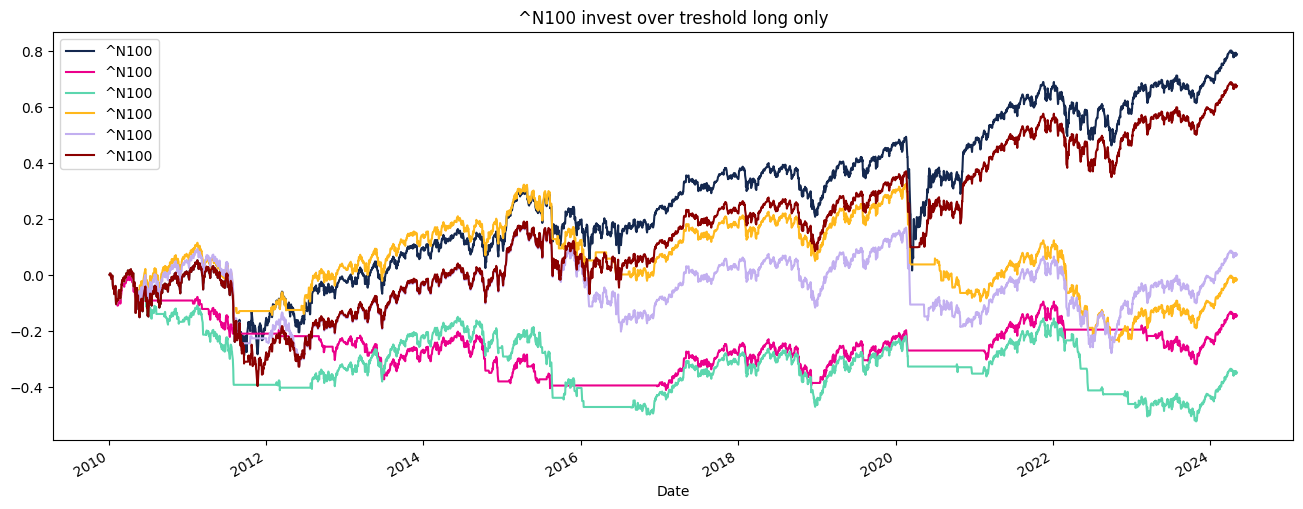

In [66]:
for col in log_returns.columns:
    strategy_treshold = strategy_testing(log_vars[col],log_returns[col],2,starting_date = '2010-01-01')
    
    plt.figure(figsize = (16,6))
    plt.title(col + ' invest over treshold indicator  short allowed')
    
    strategy_treshold.returns.cumsum().plot(legend = 'initial indicator')#.rolling(252).mean().plot()
    strategy_treshold.treshold_long_short(0.05,is_long_only = False).cumsum().plot(legend = 'treshold 0.05')#.rolling(252).mean().plot()
    strategy_treshold.treshold_long_short(0.1,is_long_only = False).cumsum().plot(legend = 'treshold 0.1')#.rolling(252).mean().plot()
    strategy_treshold.treshold_long_short(0.15,is_long_only = False).cumsum().plot(legend = 'treshold 0.15')#.rolling(252).mean().plot()
    strategy_treshold.treshold_long_short(0.2,is_long_only = False).cumsum().plot(legend = 'treshold 0.2')#.rolling(252).mean().plot()
    strategy_treshold.treshold_long_short(0.3,is_long_only = False).cumsum().plot(legend = 'treshold 5')#.rolling(252).mean().plot()
    plt.legend();

    plt.figure(figsize = (16,6))
    plt.title(col + ' invest over treshold long only')
    
    strategy_treshold.returns.cumsum().plot(legend = 'initial indicator')#.rolling(252).mean().plot()
    strategy_treshold.treshold_long_short(0.05,is_long_only = True).cumsum().plot(legend = 'treshold 0.05')#.rolling(252).mean().plot()
    strategy_treshold.treshold_long_short(0.1,is_long_only = True).cumsum().plot(legend = 'treshold 0.1')#.rolling(252).mean().plot()
    strategy_treshold.treshold_long_short(0.15,is_long_only = True).cumsum().plot(legend = 'treshold 0.15')#.rolling(252).mean().plot()
    strategy_treshold.treshold_long_short(0.2,is_long_only = True).cumsum().plot(legend = 'treshold 0.2')#.rolling(252).mean().plot()
    strategy_treshold.treshold_long_short(0.3,is_long_only = True).cumsum().plot(legend = 'treshold 5')#.rolling(252).mean().plot()
    plt.legend();

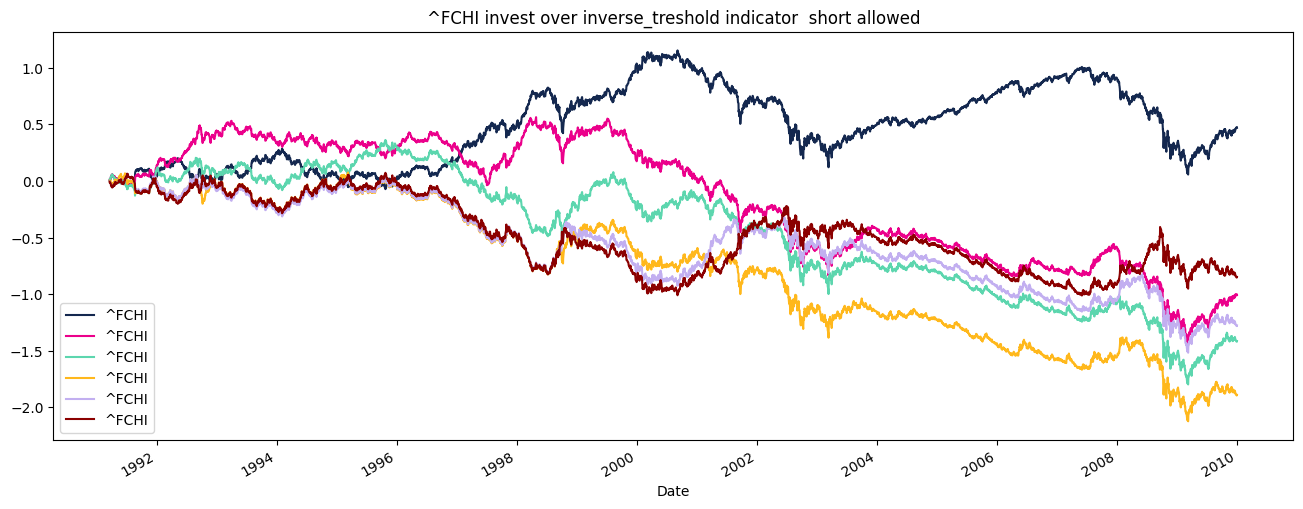

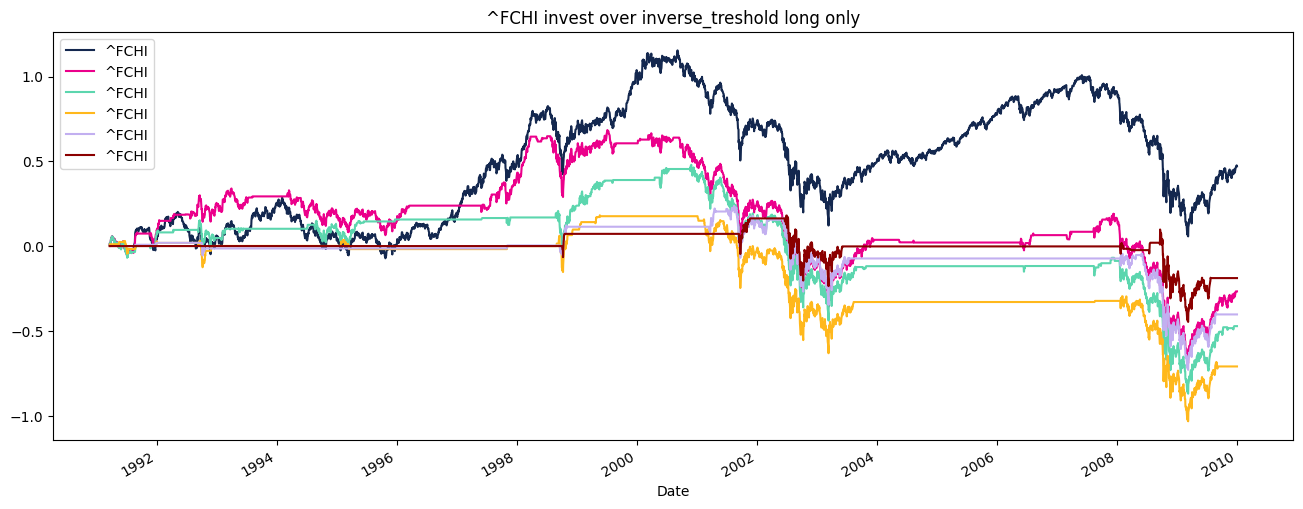

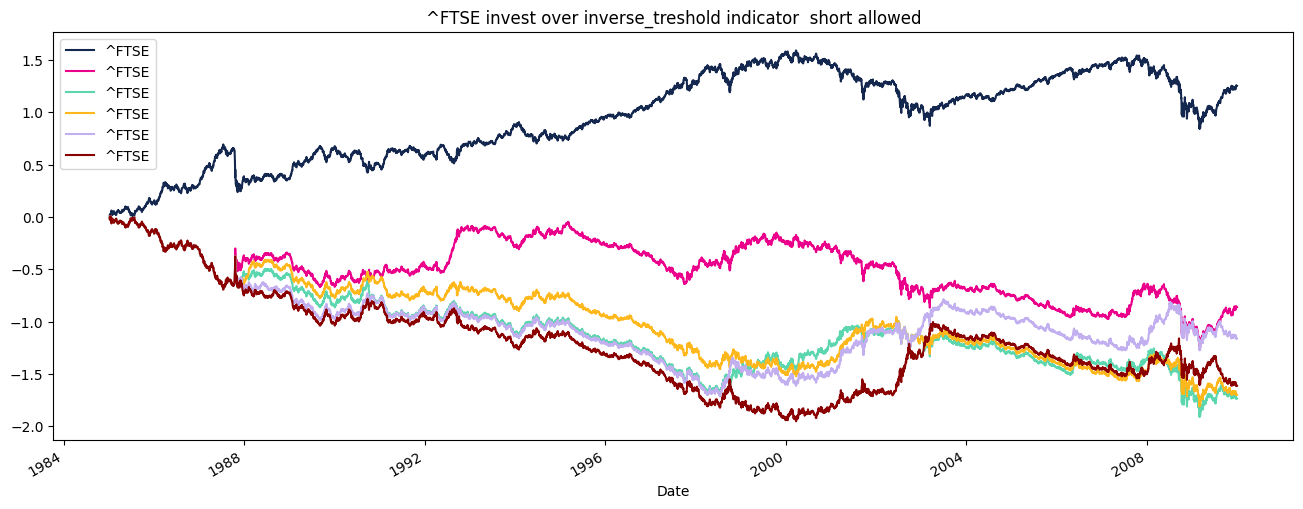

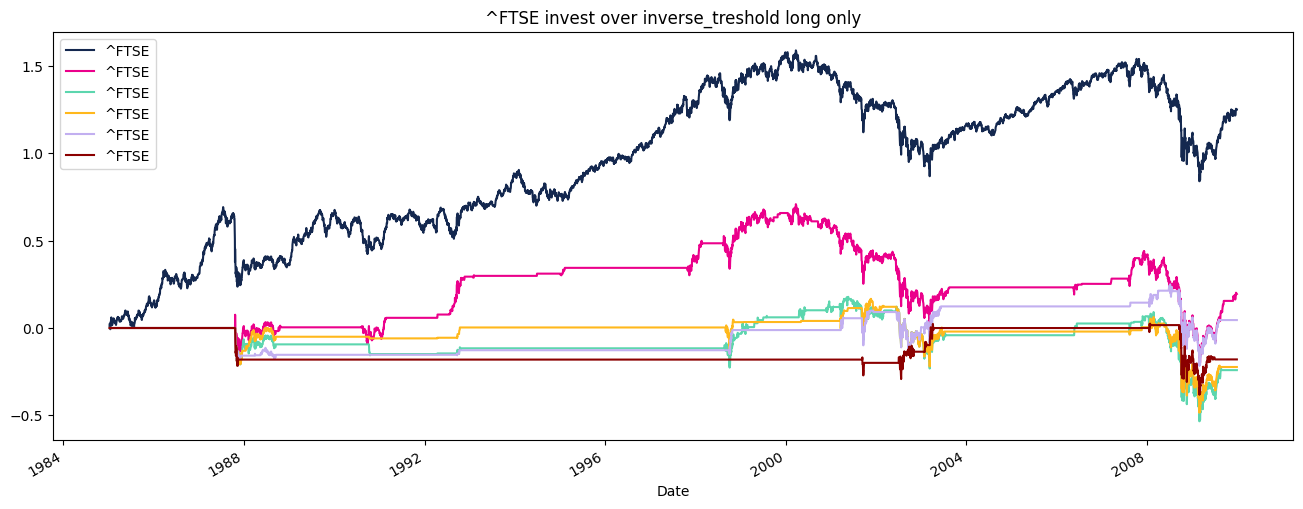

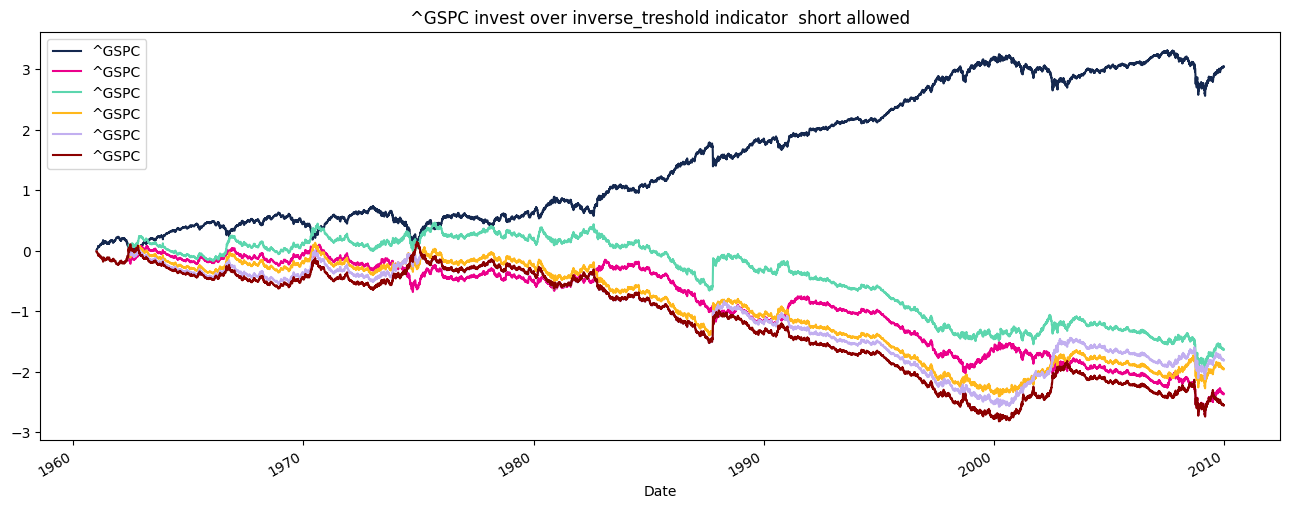

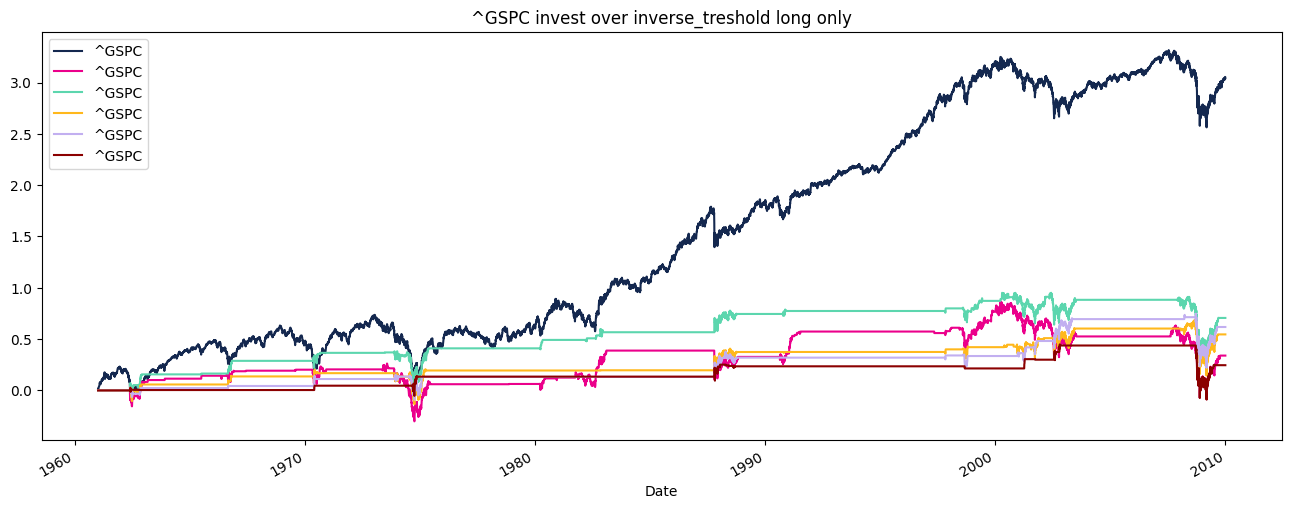

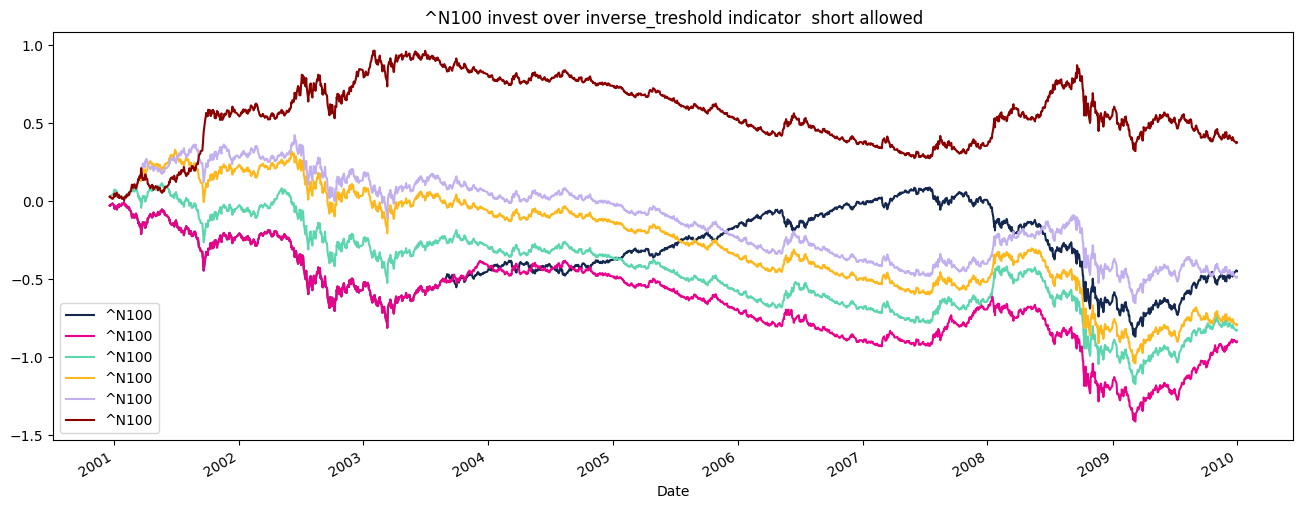

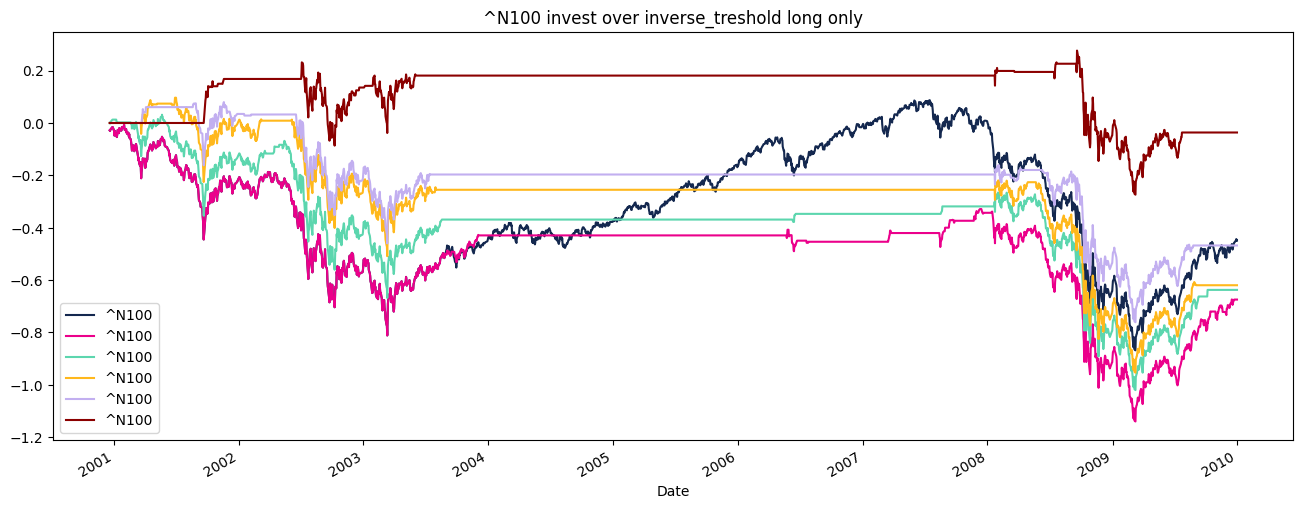

In [71]:
for col in log_returns.columns:
    strategy_treshold = strategy_testing(log_vars[col],log_returns[col],2,ending_date = '2010-01-01')
    
    plt.figure(figsize = (16,6))
    plt.title(col + ' invest over inverse_treshold indicator  short allowed')
    
    strategy_treshold.returns.cumsum().plot(legend = 'initial indicator')#.rolling(252).mean().plot()
    strategy_treshold.inverse_treshold_long_short(0.05,is_long_only = False).cumsum().plot(legend = 'treshold 0.05')#.rolling(252).mean().plot()
    strategy_treshold.inverse_treshold_long_short(0.1,is_long_only = False).cumsum().plot(legend = 'treshold 0.1')#.rolling(252).mean().plot()
    strategy_treshold.inverse_treshold_long_short(0.15,is_long_only = False).cumsum().plot(legend = 'treshold 0.15')#.rolling(252).mean().plot()
    strategy_treshold.inverse_treshold_long_short(0.2,is_long_only = False).cumsum().plot(legend = 'treshold 0.2')#.rolling(252).mean().plot()
    strategy_treshold.inverse_treshold_long_short(0.3,is_long_only = False).cumsum().plot(legend = 'treshold 5')#.rolling(252).mean().plot()
    plt.legend();

    plt.figure(figsize = (16,6))
    plt.title(col + ' invest over inverse_treshold long only')
    
    strategy_treshold.returns.cumsum().plot(legend = 'initial indicator')#.rolling(252).mean().plot()
    strategy_treshold.inverse_treshold_long_short(0.05,is_long_only = True).cumsum().plot(legend = 'treshold 0.05')#.rolling(252).mean().plot()
    strategy_treshold.inverse_treshold_long_short(0.1,is_long_only = True).cumsum().plot(legend = 'treshold 0.1')#.rolling(252).mean().plot()
    strategy_treshold.inverse_treshold_long_short(0.15,is_long_only = True).cumsum().plot(legend = 'treshold 0.15')#.rolling(252).mean().plot()
    strategy_treshold.inverse_treshold_long_short(0.2,is_long_only = True).cumsum().plot(legend = 'treshold 0.2')#.rolling(252).mean().plot()
    strategy_treshold.inverse_treshold_long_short(0.3,is_long_only = True).cumsum().plot(legend = 'treshold 5')#.rolling(252).mean().plot()
    plt.legend();

In [112]:
def assess_strategies(strategy_results, risk_free_rates = [0.02]):
    results = pd.DataFrame(columns = ['annualized return', 'annualized std','max drawdown'])

    for portfolio in strategy_results.columns:
        std_ = strategy_results[portfolio].std()*np.sqrt(251)
        ret_ = ((1+strategy_results[portfolio]).prod()**(251/strategy_results.shape[0]))-1
        portfolio_growth = (1+strategy_results[portfolio]).cumprod()
        
        results.loc[portfolio,'annualized std'] = round(std_,3)
        results.loc[portfolio,'annualized return'] = round(ret_,3)
        results.loc[portfolio,'max drawdown'] = round(np.max(1 - portfolio_growth.expanding().min() / portfolio_growth.expanding().max()),3)
        for rf in risk_free_rates:
            results.loc[portfolio,'SR '+str(rf)] = round((ret_-rf) / std_,3)
            
    for rf in risk_free_rates:
        #results['SR '+str(rf)] = results['SR '+str(rf)].astype(object)
        results.loc[results['SR '+str(rf)] < 0, 'SR '+str(rf)] = 0
        
    return results

res_returns = assess_strategies(returns, risk_free_rates = [0])
res_returns_1 = assess_strategies(returns_of_strategies_1, risk_free_rates = [0])
res_returns_2 = assess_strategies(returns_of_strategies_2, risk_free_rates = [0])
res_returns_3 = assess_strategies(returns_of_strategies_3, risk_free_rates = [0])
res_returns_4 = assess_strategies(returns_of_strategies_4, risk_free_rates = [0])
res_returns_5 = assess_strategies(returns_of_strategies_5, risk_free_rates = [0])